# Introducción

En este proyecto vamos a realizar un proyecto guiado en donde vamos a crear un algoritmo que identifique noticias falsas.
Para ello vamos a crear in modelo sequencial donde será entrenado a reconocer "fake news".

El proyecto se llevará a cabo de la siguiente manera:

1. Importar librerías necesarias para la creación del algoritmo, análisis de información y transformación de datos.
2. Realizar un análisis exploratorio de datos.
3. Limpieza de datos y transformación.
4. Visualización de la data de manera gráfica.
5. Preparar data para tokenizar y padding (rellenar).
6. Construir y entrenar modelo.
7. Evaluar desempeño del modelo.

# 1. Importar librerías y datasets

En esta sección vamos a importar las librerías necesarias para realizar nuestro proyecto.
En esta caso utilizaremos TensorFlow para la creación del modelo, plotly para la representación gráfica del modelo, nltk para tokenizar nuestra data, spacy para el procesamiento de datos, WordCloud como herramienta de visualización y gensim para el procesamiento de datos no supervisado.
También utilizaremos pandas para la lectura de data, numpy para vectorización y seaborn para graficar data.

In [2]:
!pip install --upgrade tensorflow


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install plotly
!pip install --upgrade nbformat
!pip install nltk
!pip install spacy
!pip install WordCloud
!pip install gensim
import nltk
nltk.download('punkt')

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
df_true = pd.read_csv("True.csv")
df_fake = pd.read_csv("Fake.csv")

# 2. Análisis exploratorio de datos

En esta sección vamos a revisar la información con la que estamos trabajando y observar que debemos de hacer oara trasnformala.
Revisar si toda la data es relevanta para el modelo o podemos omitir cierta información.

In [5]:
# Creamos una nueava columna para reconocer noticias falsas de las verdaderas, este será nuestro objetivo de entrenamiento.
df_true['isfake'] = 0
df_true.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  isfake  
0  December 31, 2017        0  
1  December 29, 2017        0  
2  December 31, 2017        0  
3  December 30, 2017        0  
4  December 29, 2017        0

In [6]:
df_fake['isfake'] = 1
df_fake.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  isfake  
0  December 31, 2017       1  
1  December 31, 2017       1  
2  December 30, 2017       1  
3  December 29, 2017       1  
4  December 25, 2017       1

In [7]:
# Concatenamos las bases de datos para tener la data completa en un sólo dataframe
df = pd.concat([df_true, df_fake]).reset_index(drop = True)
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

                     date  isfake  
0      December 31, 2017        0  
1      December 29, 2017        0  
2      December 31, 2017        0  
3      December 30, 2017        0  
4      December 29, 2017        0  
...                   ...     ...  
44893    January 16, 2016       1  
44894    January 16, 2016       1  
44895    January 15, 2016       1  
44896    January 14, 2016       1  
44897    January 12, 2016       1  

[44898 rows x 5 columns]

In [8]:
#Quitamos data no relevante para entrenar el modelo, en este caso la fecha no es necesaria para nuestro modelo
df.drop(columns = ['date'], inplace = True)

In [9]:
# Combinamos el título del artículo con el texto, de tal manera que tengasmos la información completa de la noticia y creamos una nueva columna
df['original'] = df['title'] + ' ' + df['text']
df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  isfake  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews       0   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews       0   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews       0   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews       0   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews       0   

                                            original  
0  As U.S. budget fight looms, Republicans flip t...  
1  U.S. military to accept transgender recruits o...  
2  Senior U.S. Republican senator: 'Let Mr. Muell...  
3  FBI Russia probe helped by Australian diplomat...  
4  Trump wants Postal Service to charge 'much mor...

# 3. Limpieza de datos y trasnformación

En esta sección vamos a limpiar los datos, dejando afuera los "stopwords" estas son palabras de conjunción u otras palabras que solo causen ruido al entrenar el modelo.
Estas palabras no dan valor al momento que entrenamos el modelo.
También realizaremos un porceso de tokenización e unión para tener las palabras importantes de las noticias y entrenarlas.

In [10]:
# Descargamos las "stopwords" que se usaran para limpiar la data
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
# Obtenemos las palabras de "stopwords" necesarias para entrenar un modelo que recibe noticias en inglés y agregamos palabras para enriquecer nuestra limpieza
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [12]:
# Definimos función para remover "stopwords" y removemos palabras que tengan menos de dos letras, ya que estás sólo causan ruido a nuestro modelo
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
            
    return result

In [13]:
# Aplicamos la función al data frame y creamos una nueva columna con los datos limpios.
df['clean'] = df['original'].apply(preprocess)

In [14]:
# Vemos como se ve una de las noticias antes de la limpieza
df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

In [15]:
# Vemos como se ve una de las noticias después de limpiarla y tokenizarla
print(df['clean'][0])

['budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script', 'washington', 'reuters', 'head', 'conservative', 'republican', 'faction', 'congress', 'voted', 'month', 'huge', 'expansion', 'national', 'debt', 'cuts', 'called', 'fiscal', 'conservative', 'sunday', 'urged', 'budget', 'restraint', 'keeping', 'sharp', 'pivot', 'republicans', 'representative', 'mark', 'meadows', 'speaking', 'face', 'nation', 'drew', 'hard', 'line', 'federal', 'spending', 'lawmakers', 'bracing', 'battle', 'january', 'return', 'holidays', 'wednesday', 'lawmakers', 'begin', 'trying', 'pass', 'federal', 'budget', 'fight', 'likely', 'linked', 'issues', 'immigration', 'policy', 'november', 'congressional', 'election', 'campaigns', 'approach', 'republicans', 'seek', 'control', 'congress', 'president', 'donald', 'trump', 'republicans', 'want', 'budget', 'increase', 'military', 'spending', 'democrats', 'want', 'proportional', 'increases', 'defense', 'discretionary', 'spending', 'programs', 'support', 'educati

In [16]:
# Revisamos nuestro DF con la data limpia
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

       isfake                                           original  \
0           0  As U.S. budget fight looms, Republicans flip t...   
1           0  U.S. military to accept transgender recruits o...   
2           0  Senior U.S. Republican senator: 'Let Mr. Muell...   
3           0  FBI Russia probe helped by Australian diplomat...   
4           0  Trump wants Postal Service to charge 'much mor...   
...       ...                                                ...   
44893       1  McPain: John McCain Furious That Iran Treated ...   
44894       1  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895       1  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896       1  How to Blow $700 Million: Al Jazeera America F...   
44897       1  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                   clean  
0      [budget, fight, looms, republicans, flip, fisc...  
1      [military, accept, transgender, recruits, mond...  
2      [senior, republican, senator, mueller, washing...  
3      [russia, probe, helped, australian, diplomat, ...  
4      [trump, wants, postal, service, charge, amazon...  
...                                                  ...  
44893  [mcpain, john, mccain, furious, iran, treated,...  
44894  [justice, yahoo, settles, mail, privacy, class...  
44895  [sunnistan, allied, safe, zone, plan, territor...  
44896  [blow, million, jazeera, america, finally, cal...  
44897  [navy, sailors, held, iranian, military, signs...  

[44898 rows x 6 columns]

In [17]:
# Creamos una lista que represente todas las palabras presentes en el dataset
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)


In [18]:
list_of_words

['budget',
 'fight',
 'looms',
 'republicans',
 'flip',
 'fiscal',
 'script',
 'washington',
 'reuters',
 'head',
 'conservative',
 'republican',
 'faction',
 'congress',
 'voted',
 'month',
 'huge',
 'expansion',
 'national',
 'debt',
 'cuts',
 'called',
 'fiscal',
 'conservative',
 'sunday',
 'urged',
 'budget',
 'restraint',
 'keeping',
 'sharp',
 'pivot',
 'republicans',
 'representative',
 'mark',
 'meadows',
 'speaking',
 'face',
 'nation',
 'drew',
 'hard',
 'line',
 'federal',
 'spending',
 'lawmakers',
 'bracing',
 'battle',
 'january',
 'return',
 'holidays',
 'wednesday',
 'lawmakers',
 'begin',
 'trying',
 'pass',
 'federal',
 'budget',
 'fight',
 'likely',
 'linked',
 'issues',
 'immigration',
 'policy',
 'november',
 'congressional',
 'election',
 'campaigns',
 'approach',
 'republicans',
 'seek',
 'control',
 'congress',
 'president',
 'donald',
 'trump',
 'republicans',
 'want',
 'budget',
 'increase',
 'military',
 'spending',
 'democrats',
 'want',
 'proportional',
 '

In [19]:
# Revisamos la cantidad palabras presentes en nuestro dataset
len(list_of_words)

9276947

In [20]:
# Revisamos el número de palabras únicas presentes en nuestro datset
total_words = len(list(set(list_of_words)))
total_words

108704

In [21]:
# Unimos las palabras para usar nuestro dataset de palabras tokenizadas
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))

In [22]:
# Revisamos como queda nuestro DF
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

       isfake                                           original  \
0           0  As U.S. budget fight looms, Republicans flip t...   
1           0  U.S. military to accept transgender recruits o...   
2           0  Senior U.S. Republican senator: 'Let Mr. Muell...   
3           0  FBI Russia probe helped by Australian diplomat...   
4           0  Trump wants Postal Service to charge 'much mor...   
...       ...                                                ...   
44893       1  McPain: John McCain Furious That Iran Treated ...   
44894       1  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895       1  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896       1  How to Blow $700 Million: Al Jazeera America F...   
44897       1  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                   clean  \
0      [budget, fight, looms, republicans, flip, fisc...   
1      [military, accept, transgender, recruits, mond...   
2      [senior, republican, senator, mueller, washing...   
3      [russia, probe, helped, australian, diplomat, ...   
4      [trump, wants, postal, service, charge, amazon...   
...                                                  ...   
44893  [mcpain, john, mccain, furious, iran, treated,...   
44894  [justice, yahoo, settles, mail, privacy, class...   
44895  [sunnistan, allied, safe, zone, plan, territor...   
44896  [blow, million, jazeera, america, finally, cal...   
44897  [navy, sailors, held, iranian, military, signs...   

                                            clean_joined  
0      budget fight looms republicans flip fiscal scr...  
1      military accept transgender recruits monday pe...  
2      senior republican senator mueller washington r...  
3      russia probe helped australian diplomat washin...  
4      trump wants postal service charge amazon shipm...  
...                                                  ...  
44893  mcpain john mccain furious iran treated sailor...  
44894  justice yahoo settles mail privacy class actio...  
44895  sunnistan allied safe zone plan territorial bo...  
44896  blow million jazeera america finally calls qui...  
44897  navy sailors held iranian military signs neoco...  

[44898 rows x 7 columns]

In [23]:
# Vemos un ejemplo de como queda nuestra data oara el entrenamiento del modelo
df['clean_joined'][0]

'budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats saying need government raise 

# 4. Visualizamos la data de manera gráfica 

Esto nos sirve para comprender con qué estasmo trabajando, si hay un sesgo en la información o alguna tendencia.

C:\Users\USER\AppData\Local\Temp\ipykernel_7392\3631104819.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y = "subject", data = df, palette='viridis')


<Axes: xlabel='count', ylabel='subject'>

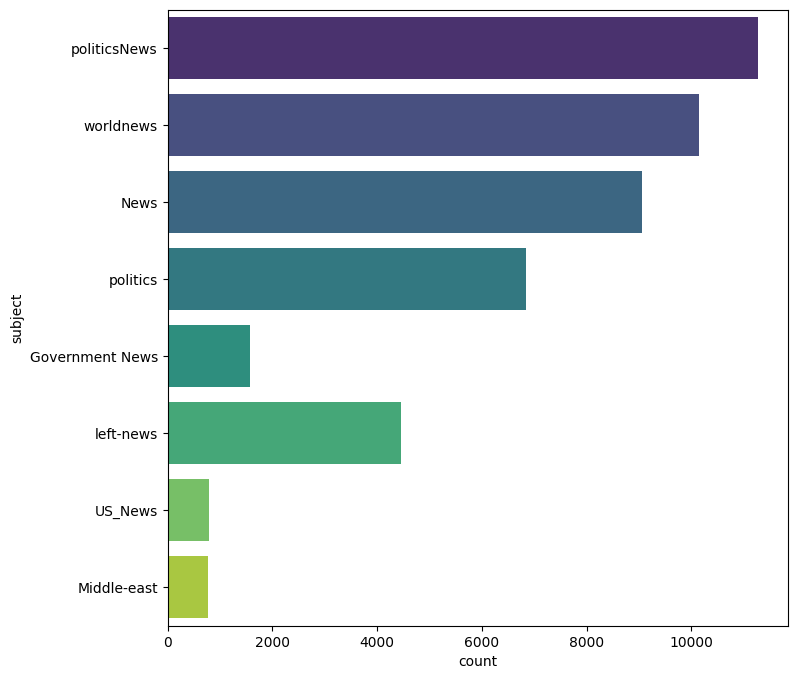

In [24]:
# Creamos un gráfico para concer que tipo de noticias existen dentro de nuestro dataset
plt.figure(figsize = (8, 8))
sns.countplot(y = "subject", data = df, palette='viridis')

C:\Users\USER\AppData\Local\Temp\ipykernel_7392\2326404901.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y = "isfake", data = df, palette='viridis')


<Axes: xlabel='count', ylabel='isfake'>

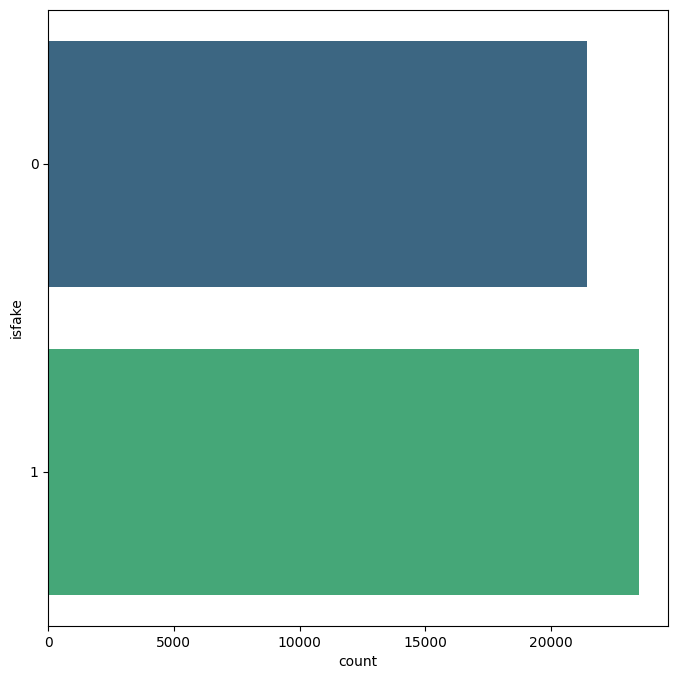

In [25]:
plt.figure(figsize = (8, 8))
sns.countplot(y = "isfake", data = df, palette='viridis')

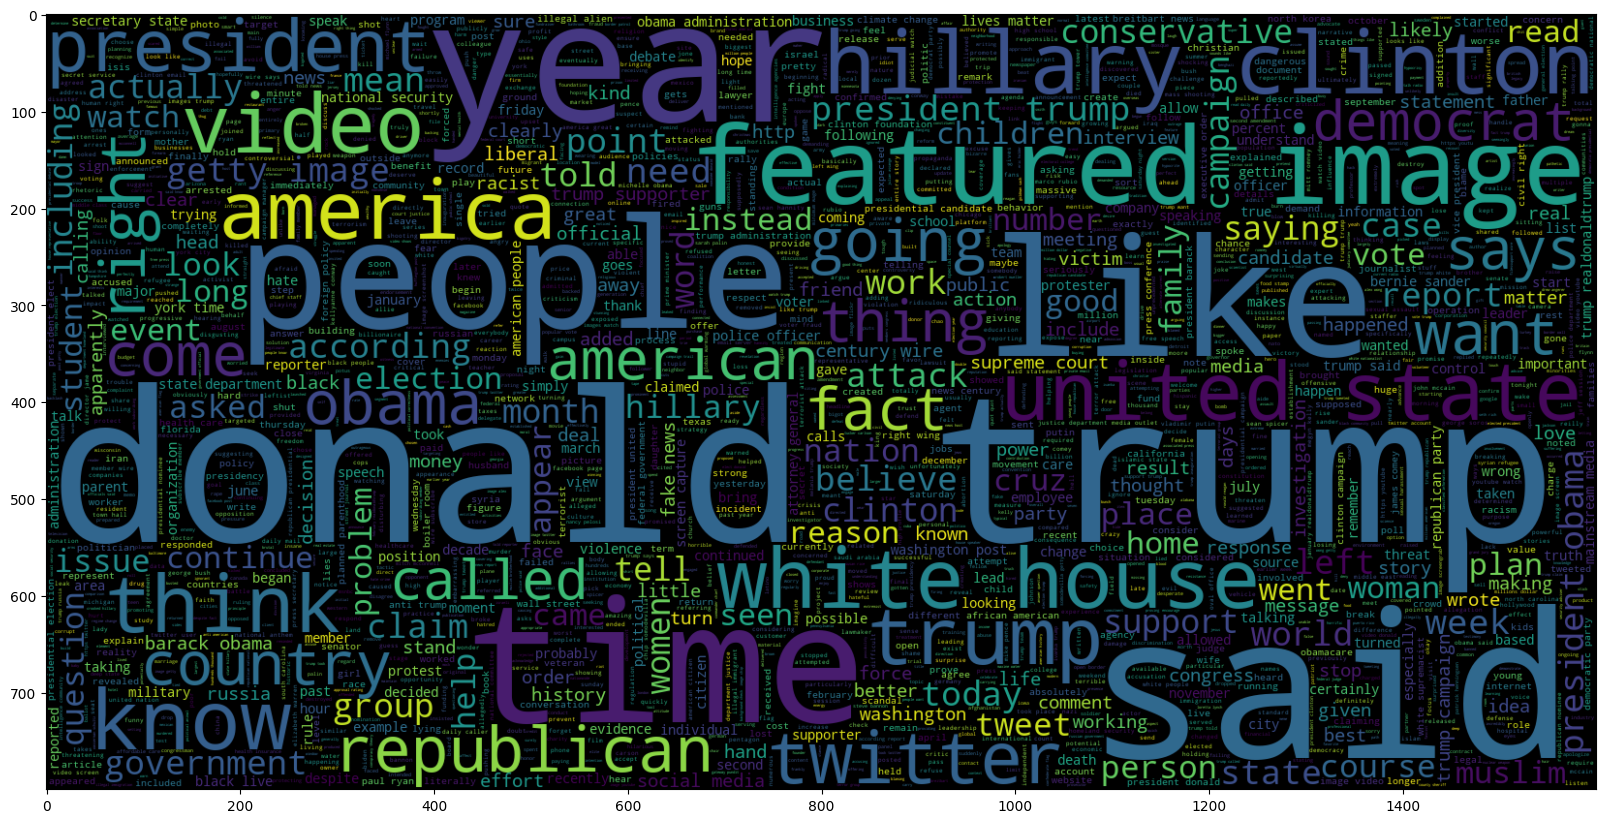

In [26]:
# veamos un WordCloaud para la información falsa
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 1].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

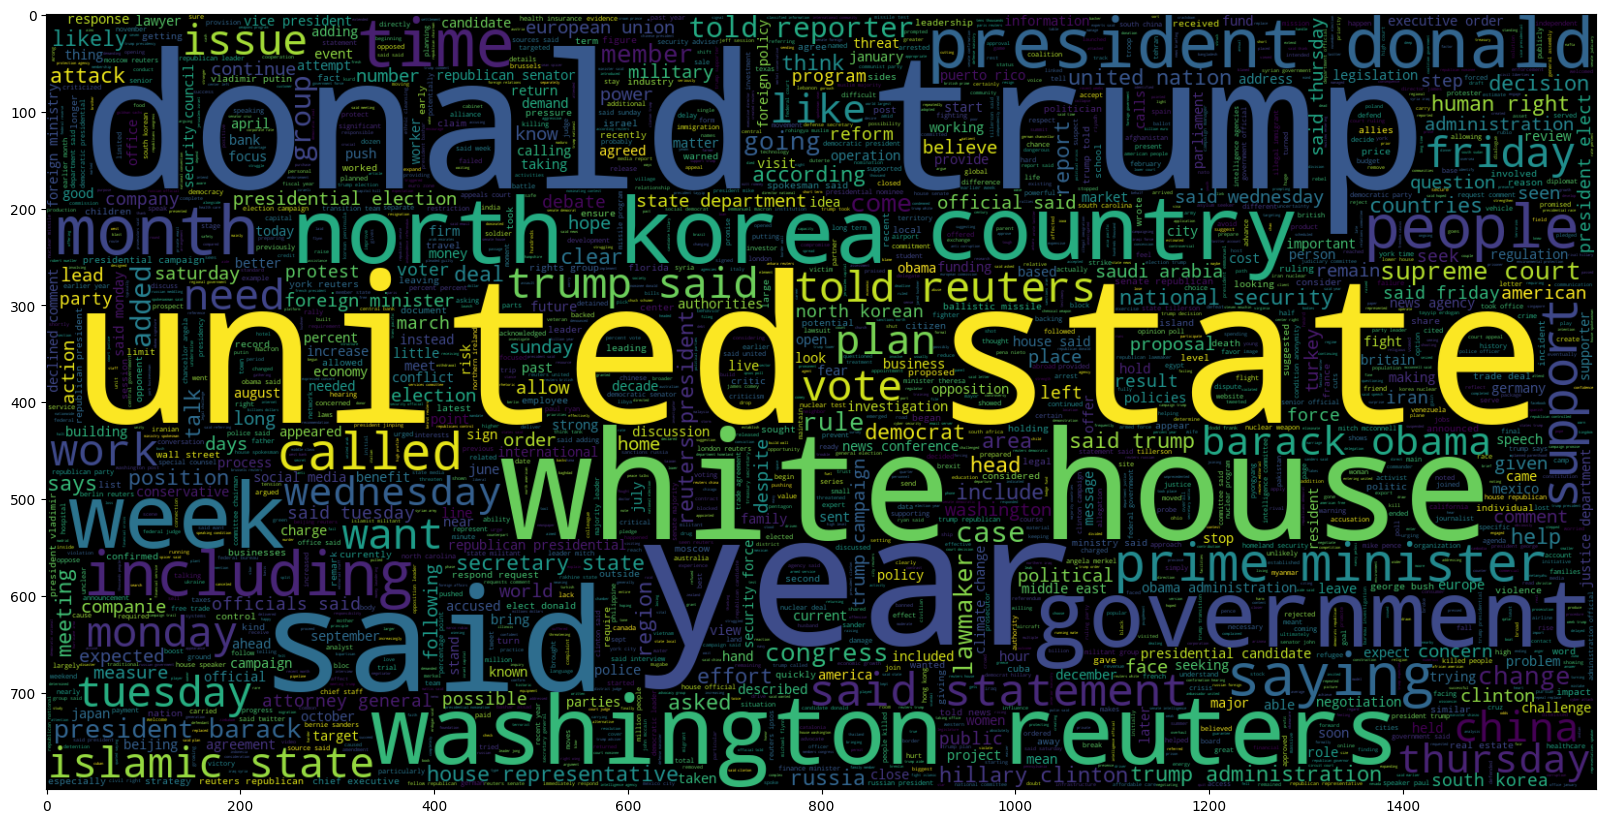

In [27]:
# Hagamos lo mismo para las noticias reales
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 0].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

In [28]:
from nltk import word_tokenize
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [29]:
# Revisamos la longitud del string más largo, esto nos va a servir para poder realizar el padding
maxlen = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 4405


In [30]:
# Visualizamos la distribución de número de palabras por texto
import plotly.express as px
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined], nbins = 100)
fig.show()

En este caso podemos ver que el eje X representa la cantidad de tokens por texo y el eje Y nos muestra el conteo de textos.

# 5. Preparamos data para tokenización y padding(relleno)

Esta etapa es muy importante, ya que al tokenizar estamos transformando el texto en números que el modelo puede utilizar para el entrenamiento y predicción.
También haremos lo que se llama padding, que es rellenar los vectores de tokens con ceros para que todos los vectores tengas la misma longitud.

In [31]:
# Primero separamos la data en entrenamiento y validación. 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size = 0.2)

In [32]:
# Tokenizamos nuestra data, indicamos que el número de palabras equivale al número total de palabras únicas
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train) # Fit on texts indexa las palabras
train_sequences = tokenizer.texts_to_sequences(x_train) # Toma las palabras y le asigna su valor numérico (interger) correspondiente
test_sequences = tokenizer.texts_to_sequences(x_test)


In [33]:
#Veamos como se ve nuestra lista de datos como un vector tokenizado en números
print("The encoding for document\n",df.clean_joined[0],"\n is : ",train_sequences[0])

The encoding for document
 budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats say

In [34]:
# Agregaremos el páging usando el resultado previo de máximo de longitud 
padded_train = pad_sequences(train_sequences,maxlen = 4405, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 4405, padding= 'post', truncating = 'post') 

In [35]:
# Verificamos que el padding se haya ejecutado de manera correcta
for i,doc in enumerate(padded_train[:2]):
     print("The padded encoding for document",i+1," is : ",doc)

The padded encoding for document 1  is :  [3524  623   23 ...    0    0    0]
The padded encoding for document 2  is :  [   1    3 4685 ...    0    0    0]


# 6. Construir nuestro modelo y entrenamiento

En esta sección vamos a contruir nuestro modelo asignando las capas deseada para entrenarlo, debemos elegir cantidad de neuronas por capas, modo de cativación y mñetrica de error.

In [36]:
# Cargamos modelo Sequential en una variable
model = Sequential()

# Creamos capa de incrustación para representar datos reales en numéricos
model.add(Embedding(total_words, output_dim = 128))


# Agregamos a la Red Neuronal Recurrente un entrenamiento bidimensional de memoría corta-largo plazo
model.add(Bidirectional(LSTM(128)))

# Creamos capas y activación
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [37]:
# Vectorizamo el resultado esperado
y_train = np.asarray(y_train)

In [ ]:
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 2)

Epoch 1/2
 32/506 ━━━━━━━━━━━━━━━━━━━━ 8:50:38 67s/step - acc: 0.6756 - loss: 0.6074

# 6. Valuación del modelo y predicciones

Ahora veamos que tan eificente es nuestro modelo, revisando que tan preciso es.
También relizaremos predicciones para validar el funcionamiento del modelo.


In [ ]:
# Hacemos predicciones sobre el modelo
pred = model.predict(padded_test)

In [ ]:
# Categorizamos las predicciones para que las que se califiquen mayores a 0.5 sean consideradas reales.
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

In [ ]:
# Medimos la precisión del modelo
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

Model Accuracy :  0.9968819599109131


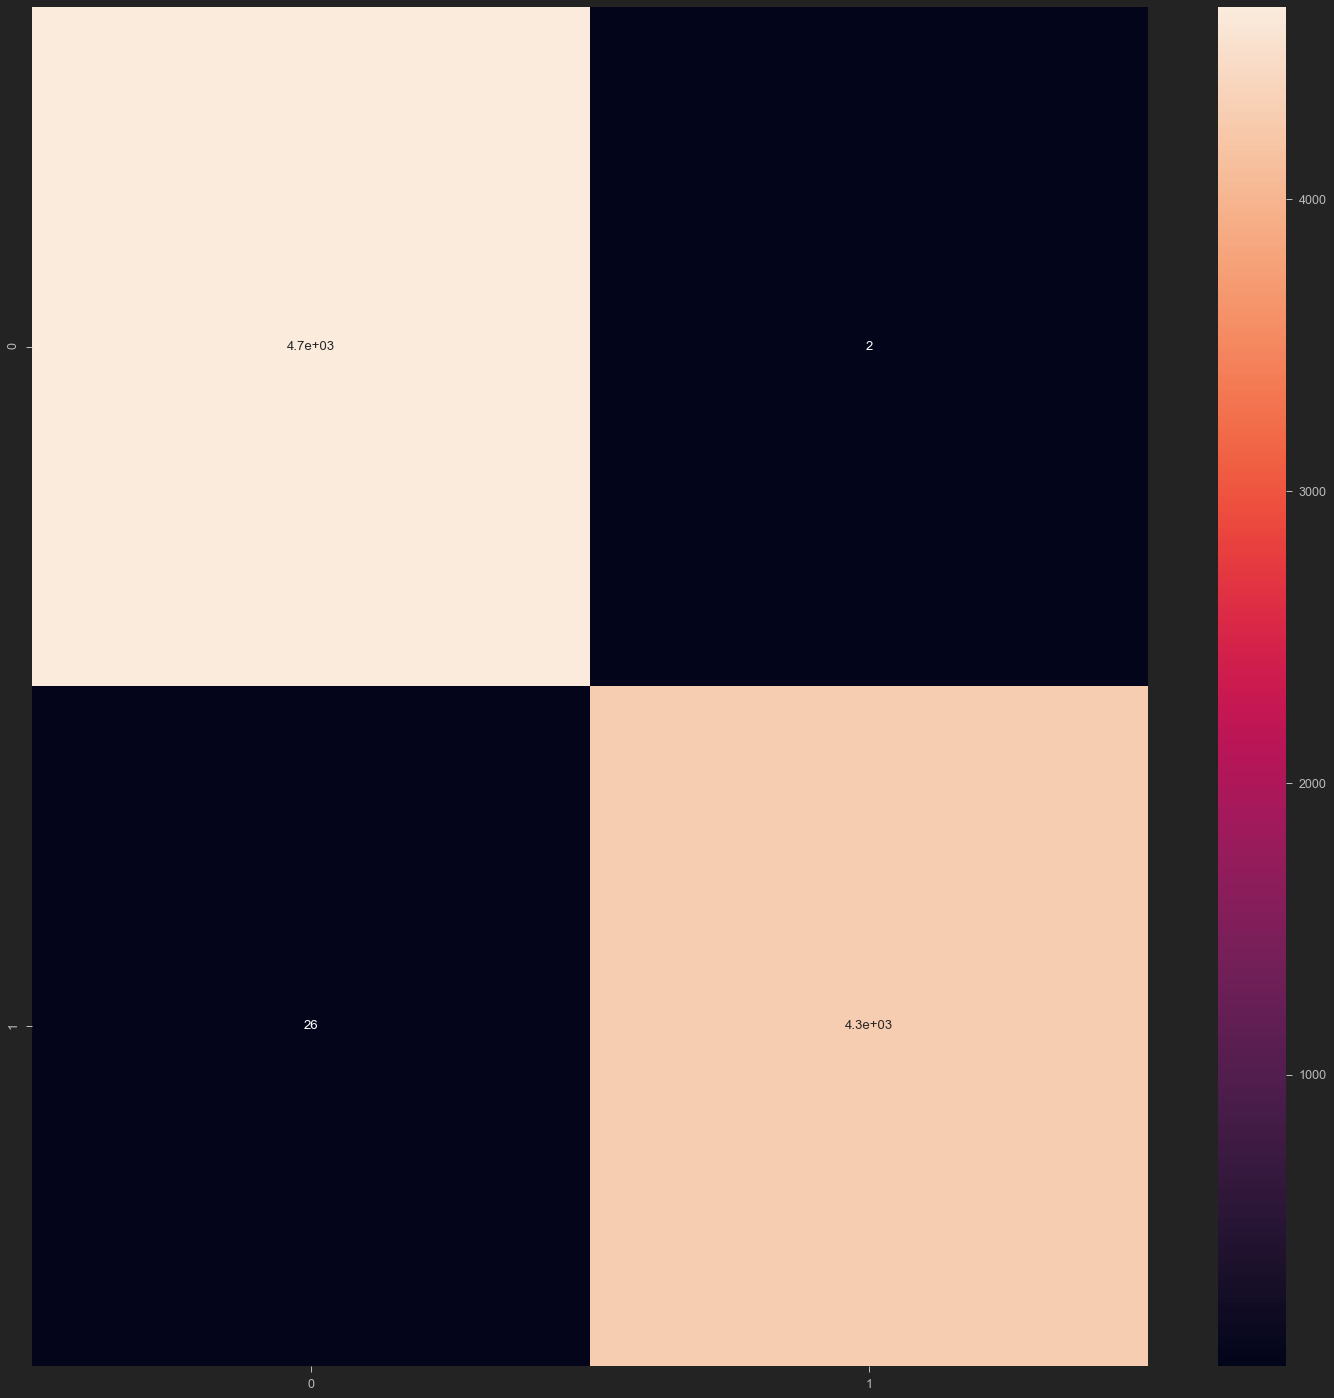

In [ ]:
# Revisamos la matrix de confusión para ver la comparación de Falsos Positivos conta Verdaderos Positivos
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (25, 25))
sns.heatmap(cm, annot = True)